In [1]:
import torch
import h5py
import matplotlib.pyplot as plt

import common
from core import *

In [2]:
def on_boundary(x):
    n = x.shape[0]
    return torch.isclose(x[:, 0], 0.0*torch.ones(n)) | \
           torch.isclose(x[:, 0], 1.0*torch.ones(n)) | \
           torch.isclose(x[:, 1], 0.0*torch.ones(n)) | \
           torch.isclose(x[:, 1], 1.0*torch.ones(n))

def mesh_from_data(path):
    data = h5py.File(path)

    geometry = torch.tensor(data["/Mesh/mesh/geometry"][...], dtype=torch.float32)
    topology = torch.tensor(data["/Mesh/mesh/topology"][...], dtype=torch.int32)
    func = torch.tensor(data["/Function/f/0"][...], dtype=torch.float32)

    return (geometry, topology, func)


def graph_from_mesh(geometry, topology, func):
    # get edges from topology
    senders, receivers = common.topology_to_edges(topology) # two way connectivity implied
    senders = senders.long()
    receivers = receivers.long()

    # compute mesh distances
    senders_pos = geometry[senders]
    receivers_pos = geometry[receivers]
    mesh_distances = torch.sqrt((senders_pos[:, 0] - receivers_pos[:, 0])**2 + (senders_pos[:, 1] - receivers_pos[:, 1])**2)

    # create edge set
    edgeset = EdgeSet(senders.to(device), receivers.to(device), mesh_distances.to(device).view(-1, 1))

    # create node features
    node_types = F.one_hot(on_boundary(geometry).long())
    node_features = torch.cat([node_types, func], dim=1)

    # create graph
    graph = MultiGraph(node_features.to(device), edgeset)
    return graph

In [3]:
# display solution
import pyvista

def display_solution(geometry, topology, scalar, name):

    n_cells = topology.shape[0]
    n_points = geometry.shape[0]

    cells_vtk = torch.cat([3*torch.ones(n_cells)[:, None], topology], dim=1).int().flatten().numpy()
    celltypes = [pyvista.CellType.TRIANGLE] * n_cells
    points = torch.cat([geometry, torch.zeros(n_points)[:, None]], dim=1).numpy()

    grid = pyvista.UnstructuredGrid(cells_vtk, celltypes, points)
    grid.point_data["u"] = scalar.numpy()
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=False)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    plotter.screenshot("solution/"+name)

In [4]:
init_mesh = mesh_from_data("data/out_poisson_initial/poisson.h5")
final_mesh = mesh_from_data("data/out_poisson_final/poisson.h5")

graph_init = graph_from_mesh(*init_mesh)
graph_final = graph_from_mesh(*final_mesh)

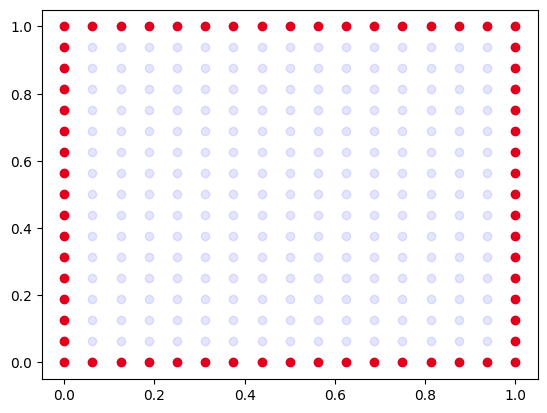

In [5]:
# visualise nodes with their types
geometry = init_mesh[0]
x_b, y_b = torch.unbind(geometry[on_boundary(geometry)], dim=1)
x, y = torch.unbind(geometry, dim=1)
plt.scatter(x_b, y_b, c='r')
plt.scatter(x, y, c='b', alpha=0.1)
plt.show()

In [6]:
# propagate solution from graph_init to graph_final
def train(model, epochs, graph_init, graph_final):
    loss_history = []

    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    
    for epoch in range(epochs):

        node_features_pred = model.forward(graph_init).flatten()
        node_features_exact = graph_final.node_features[:, -1]  # get only scalar node_features (without one-hot enc)

        loss = loss_func(node_features_pred, node_features_exact)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"epoch: {epoch+1}, loss: {loss.item()}")
        loss_history.append(loss.item())
    
    return loss_history

In [7]:
# define graphnet model
model = GraphNet(message_passing_steps=15)

In [8]:
# train graphnet model
loss_history = train(model, 500, graph_init, graph_final)

epoch: 1, loss: 0.016078487038612366
epoch: 2, loss: 0.2651432752609253
epoch: 3, loss: 0.015742437914013863
epoch: 4, loss: 0.03138825669884682
epoch: 5, loss: 0.01866302080452442
epoch: 6, loss: 0.01260082796216011
epoch: 7, loss: 0.014972850680351257
epoch: 8, loss: 0.012863295152783394
epoch: 9, loss: 0.012306424789130688
epoch: 10, loss: 0.012757961638271809
epoch: 11, loss: 0.010618350468575954
epoch: 12, loss: 0.010730712674558163
epoch: 13, loss: 0.01021072082221508
epoch: 14, loss: 0.010189464315772057
epoch: 15, loss: 0.009959923103451729
epoch: 16, loss: 0.009908466599881649
epoch: 17, loss: 0.009886409156024456
epoch: 18, loss: 0.009739874862134457
epoch: 19, loss: 0.00998756568878889
epoch: 20, loss: 0.00959757063537836
epoch: 21, loss: 0.00983194075524807
epoch: 22, loss: 0.00938981119543314
epoch: 23, loss: 0.009635316208004951
epoch: 24, loss: 0.009284457191824913
epoch: 25, loss: 0.009453636594116688
epoch: 26, loss: 0.009202939458191395
epoch: 27, loss: 0.009244896471

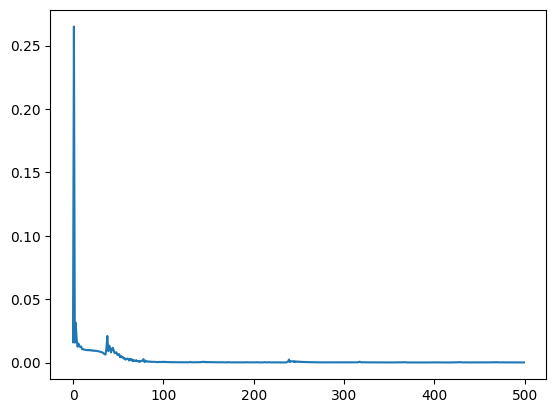

In [9]:
plt.plot(loss_history)

In [10]:
with torch.no_grad():
    scalar_pred = model.forward(graph_init).cpu()

display_solution(init_mesh[0], init_mesh[1], scalar_pred, name="solution.png")
display_solution(*final_mesh, name="exact_solution.png")